In [1]:
import pystan
import numpy as np
from scipy import stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

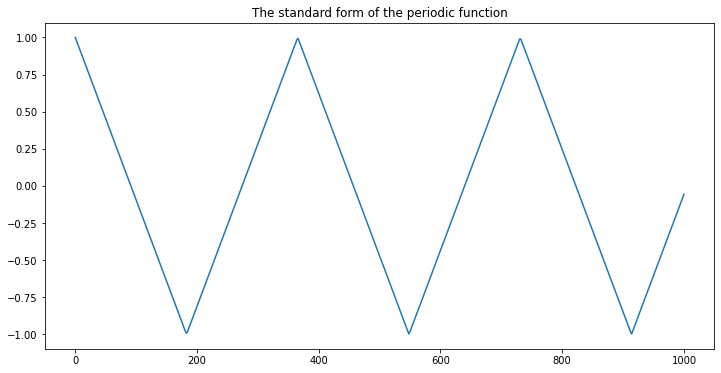

In [2]:
# I used this function from the last class for reference
def f(x, A=1, b=0, lambd=1, phi=0, sigma=0, c0=0, c1=0):
    '''
    A periodic triangle function with specified amplitude, frequency, phase,
    and optional noise added to the function value.

    Inputs:

        x (float or array): The input value(s) at which to evaluate the
          function.

        A (float): The amplitude of the function. The non-noisy function
          value will vary from -A to A. Default: 1.

        lambda (float): The frequency of the function. There will will be
          lambda waves per unit of `x`. Default: 1.

        phi (float): The phase offset of the function. The graph of the
          function moves to the left by this many waves. Note that `phi`
          is periodic in the range [0, 1], so setting `phi = 1.2` will
          have the same effect as setting `phi = 0.2` or `phi = `2.2`.
          Default: 0.

        sigma (float): The amount of noise to add to the function value,
          interpreted as the standard deviation of zero-mean Gaussian
          noise. Default: 0.

    Returns: (float or array) matching the dimensions of `x` with the
      periodic function values.
    '''
    return (b + A * (4 * abs((x / 365.5 + phi) % 1 - 0.5) - 1) + c0 * x +
            c1 * x**2 + sts.norm.rvs(0, sigma, size=np.shape(x)))


plot_x = np.linspace(0, 1000, 501)
plt.figure(figsize=(12, 6))
plt.plot(plot_x, f(plot_x, lambd=1 / 365, A=1))
plt.title('The standard form of the periodic function')
plt.show()

### Data

In [19]:
df_dates = pd.read_csv("weekly_in_situ_co2_mlo.csv")
df_dates.head()

,Day,CO2
0,3/29/1958,316.19
1,4/5/1958,317.31
2,4/12/1958,317.69
3,4/19/1958,317.58
4,4/26/1958,316.48


In [21]:
# Changing dates to 'days since first measurement'
from datetime import datetime
from datetime import timedelta
date_format = "%m/%d/%Y"
df = df_dates.copy()
df["Day"] = [(datetime.strptime(df_dates.iloc[i, 0], date_format) -
              datetime.strptime('3/29/1958', date_format)).days
             for i in range(len(df_dates))]
df.head()

,Day,CO2
0,0,316.19
1,7,317.31
2,14,317.69
3,21,317.58
4,28,316.48


### Model

In [5]:

stan_data = {
    'last_day': df.iloc[-1, 0],  
    'n': len(df),
    'n_future': 480, 
    't': df["Day"],
    'CO2': df["CO2"],  
    'lambda': 1 / 365.5
}

stan_code = """
data {
    int<lower=0> last_day;  // Day of the last measurement
    int<lower=0> n;        // The number of measurements
    real<lower=0> CO2[n];             // CO2 concentration in ppm
    int<lower=0> t[n];   // Days from first measurement
    int<lower=0> n_future; // The number of future values to predict
    real<lower=0> lambda; // Frequency
}

parameters {
    real<lower=0> A; // Amplitude
    real<lower=0> sigma; // Noise
    real<lower=0> alpha; // y-axis offset
    real<lower=0> b0; // coefficient of linear term
    real<lower=0> b1; // coefficient of quadratic term

    // We need a periodic phi
    real phi_x;
    real phi_y;
}

transformed parameters {
    real<lower=0,upper=1> phi;  // x-axis offset

    // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
    phi = atan2(phi_x, phi_y) / (2 * pi()) + 0.5;
}

model {
    // Priors
    A ~ normal(0, 5);
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    sigma ~ gamma(1, 0.3);
    alpha ~ normal(300, 50);
    b0 ~ normal(0,.1);
    b1 ~ normal(0,.1);
    
    // Likelihood
    for(i in 1:n) {
        CO2[i] ~ normal(
            alpha + b0*t[i] + b1*t[i]^2 + A * (4 * fabs(fmod(lambda*t[i] + phi, 1) - 0.5) - 1),
            sigma);
    }
}

// Generate the predicted function values for the current dates and the next n_future steps.
generated quantities {
    real CO2_present[n];
    real CO2_future[n_future];
    
    for(i in 1:n) {
        CO2_present[i] = normal_rng(
            alpha + b0*t[i] + b1*t[i]^2 + A * (4 * fabs(fmod(lambda*t[i] + phi, 1) - 0.5) - 1),
            sigma);
    }
    
    for(i in 1:n_future) {
        CO2_future[i] = normal_rng(
            alpha + b0*(i*30+last_day) + b1*(i*30+last_day)^2 + A * (4 * fabs(fmod((lambda*(i*30+last_day) + n) + phi, 1) - 0.5) - 1),
            sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d85d798a8edcde9f8c0d7ff886347f55 NOW.


In [6]:
results = stan_model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [7]:
parameters = ["alpha", 'b0', 'b1', 'A', 'phi', 'sigma']
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_d85d798a8edcde9f8c0d7ff886347f55.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean      sd   2.5%    25%     50%     75%  97.5%  n_eff   Rhat
alpha  314.72  1.2e-3    0.06 314.61 314.68  314.72  314.76 314.83   2317    1.0
b0     2.1e-3  2.6e-7  1.1e-5 2.0e-3 2.0e-3  2.1e-3  2.1e-3 2.1e-3   1787    1.0
b1    10.0e-8 1.1e-11 4.5e-10 9.9e-8 9.9e-8 10.0e-8 10.0e-8 1.0e-7   1792    1.0
A        3.48  5.7e-4    0.03   3.42   3.46    3.48     3.5   3.54   2861    1.0
phi      0.96  2.1e-5  1.4e-3   0.96   0.96    0.96    0.96   0.96   4248    1.0
sigma    1.03  2.6e-4    0.01    1.0   1.02    1.03    1.03   1.05   2245    1.0

Samples were drawn using NUTS at Thu Dec 16 10:18:33 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


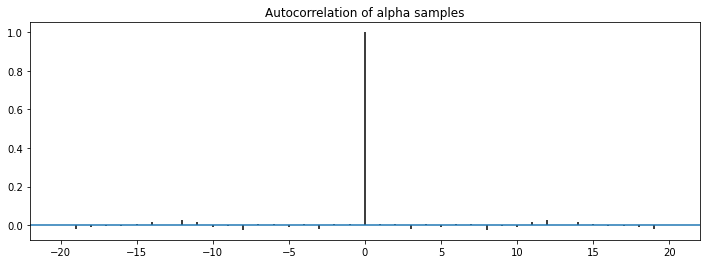

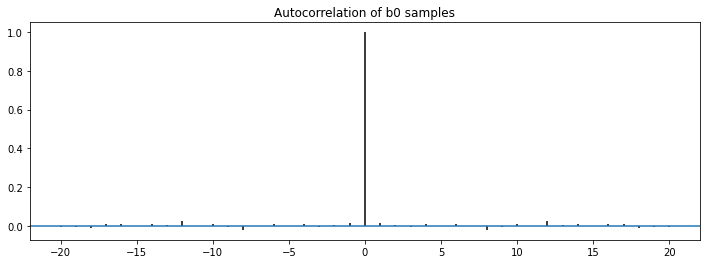

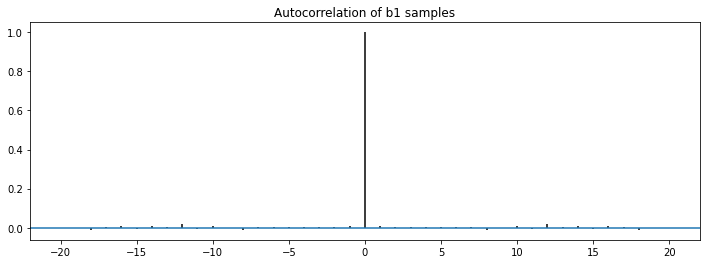

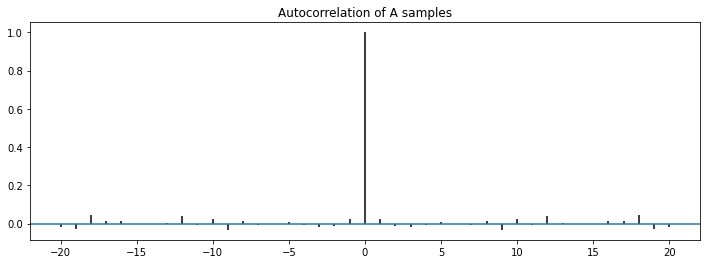

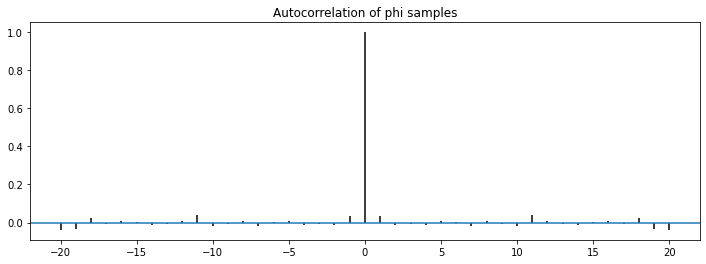

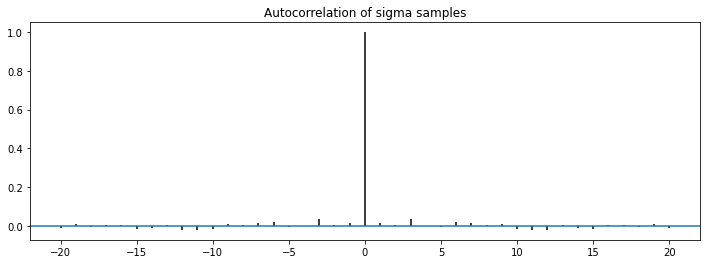

In [8]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

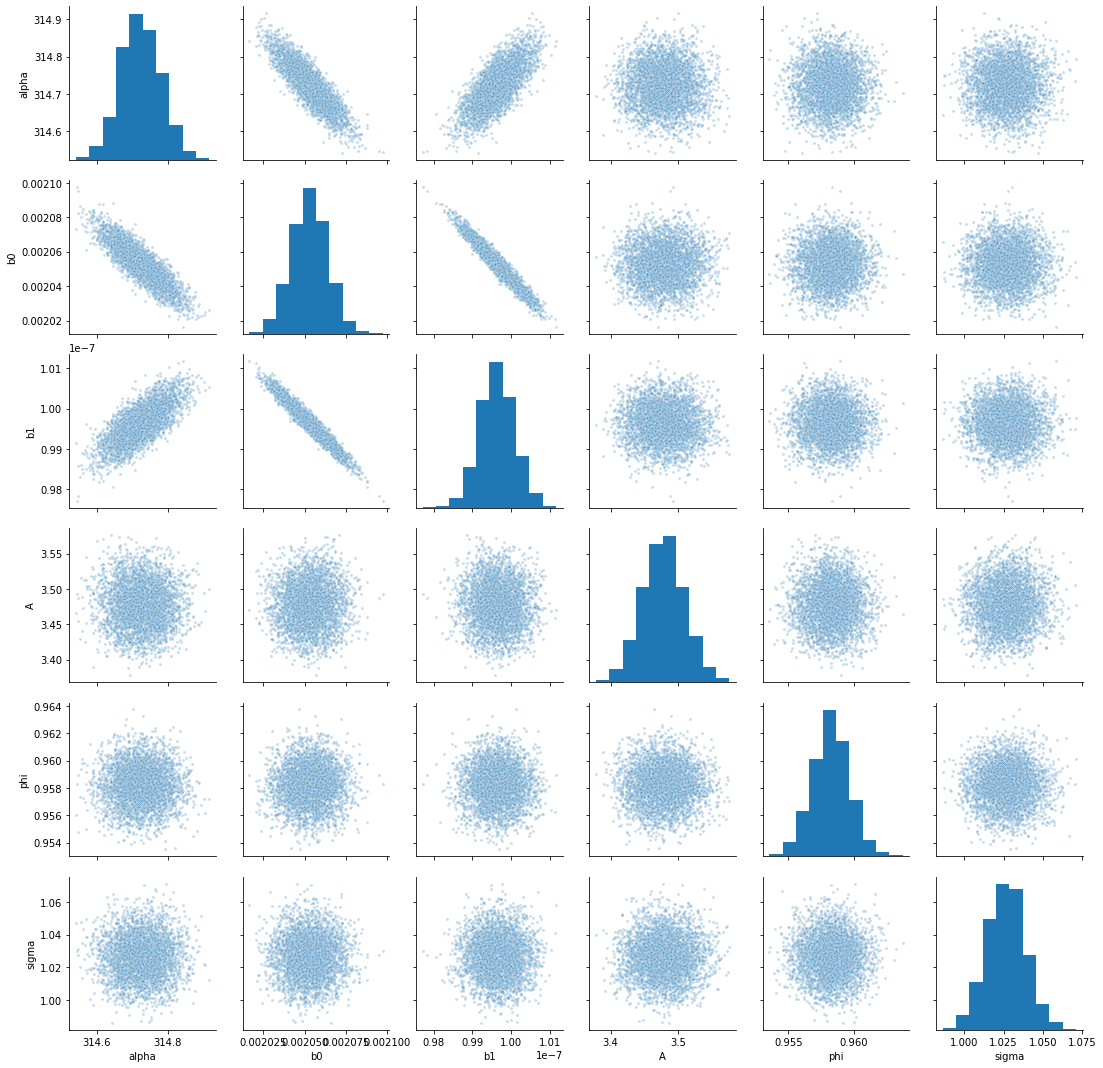

In [9]:
# Make pair plot of the posteriors over all parameters of the model.
new_df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(new_df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

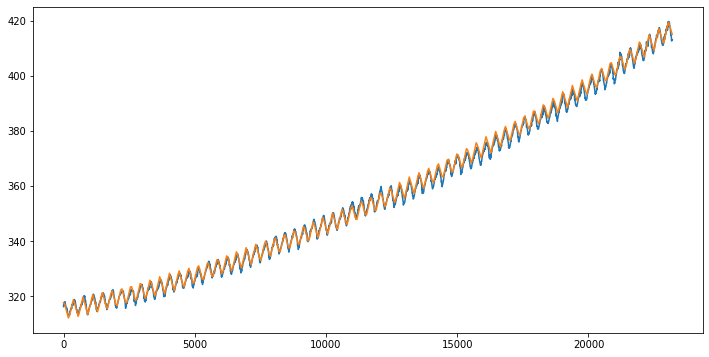

In [10]:
# Comparing model estimates with the actual data
lim = df.iloc[-1, 0]
plot_x = np.linspace(0, lim, 501)

plt.figure(figsize=(12, 6))
plt.plot(df["Day"], df["CO2"])
plt.plot(plot_x, f(plot_x, b=314.72, c0=0.0021, c1=0.0000001, A=3.48,
                   phi=0.96))

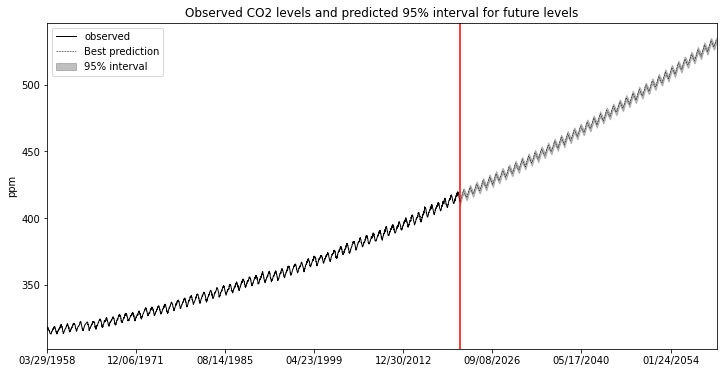

In [22]:
n = len(df)
n_future = 480
last_day = df.iloc[-1, 0]

# Plot predictions
current = samples["CO2_present"]
prediction = samples['CO2_future']
best_prediction = np.mean(prediction, axis=0)

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])
current_interval = np.percentile(current, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(df["Day"], df["CO2"], 'k-', label='observed', linewidth=1)
plt.xlim(0, last_day + n_future * 30 + 1)

# plt.plot(
#     range(last_day, last_day + n_future*30,30),
#     prediction_interval[0,:],
#     'b-', label='prediction 95% interval')
# plt.plot(
#     range(last_day, last_day + n_future*30,30),
#     prediction_interval[1,:],
#     'b-')

plt.plot(range(last_day, last_day + n_future * 30, 30),
         best_prediction,
         '--',
         color="k",
         linewidth=0.5,
         label='Best prediction')

plt.fill_between(range(last_day, last_day + n_future * 30, 30),
                 prediction_interval[0, :],
                 prediction_interval[1, :],
                 alpha=0.5,
                 color='gray',
                 label="95% interval")

# plt.plot(
#     df["Day"],
#     current_interval[0,:],
#     'b-', label='prediction 95% interval')
# plt.plot(
#     df["Day"],
#     current_interval[1,:],
#     'b-')

plt.axvline(last_day - 1, color='red')
plt.xticks([i for i in range(0, 40000, 5000)],
           [(datetime.strptime(df_dates.iloc[0, 0], date_format) +
             timedelta(days=i)).strftime(date_format)
            for i in range(0, 40000, 5000)])
plt.ylabel('ppm')
plt.legend()
plt.title('Observed CO2 levels and predicted 95% interval for future levels')
plt.savefig("prediction.png", dpi=300)
plt.show()

### Predictions

In [24]:
# Best estimate for 2060
import math
best_prediction = np.mean(prediction, axis=0)
index = math.floor(
    (datetime.strptime('1/01/2060', date_format) -
     datetime.strptime(df_dates.iloc[-1, 0], date_format)).days / 30)
levels2060 = best_prediction[index]
print(f"The CO2 levels in 2060 will be {levels2060} ppm")
print(f"Confidence interval: {[prediction_interval[0, :][index],prediction_interval[1, :][index]]}" )


The CO2 levels in 2060 will be 527.3870349345735 ppm
Confidence interval: [525.2874672037665, 529.4794221648193]


In [25]:
# When will 450 be reached
index = np.argmax(prediction_interval[0,:]>450)
date = datetime.strptime(df_dates.iloc[-1,0], date_format) + timedelta(days = int(index)*30 + 30)
print(date.strftime(date_format))

03/16/2035


### Test Statistics

In [26]:
def test_statistic(data):
    "The standard deviation of the percentage of patients that recovered in each study"
    line = np.linspace(np.mean(data[0:52]), np.mean(data[-52:-1]), len(data))
    pct_bigger = np.count_nonzero(np.array(data)>line)/len(data)
    return pct_bigger

In [27]:
# Generate and iterate over samples from the posterior distribution
replicated_statistic = []


# Get the generated data
for i in current:
    
    
    # Calculate the simulated data test statistic
    stat = test_statistic(i)

    replicated_statistic.append(stat)


# Compute test statistic on real data set
real_statistic = test_statistic(np.array(df["CO2"]))

Text(0.5, 1.0, 'P-value: 0.754')

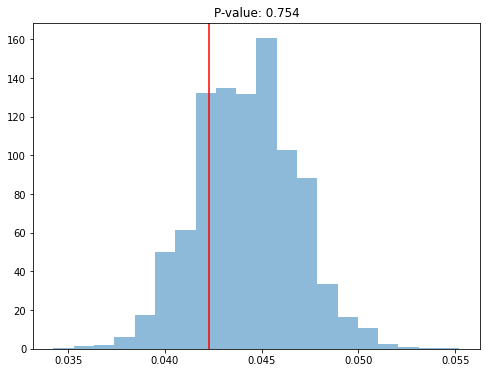

In [28]:
# Control group
plt.figure(figsize=(8, 6))
plt.hist(replicated_statistic, bins=20, alpha=0.5, density=True)
plt.axvline(real_statistic, color = "red")
plt.title("P-value: %.3f" % (
    np.mean(np.array(replicated_statistic) > real_statistic)))

In [29]:
real_statistic

0.04225786551511413

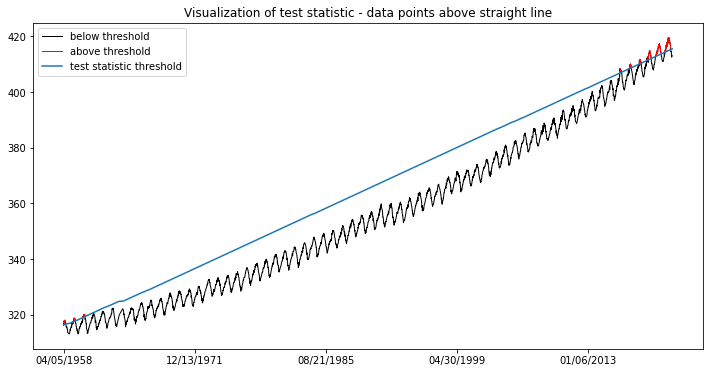

In [30]:
data = np.array(df["CO2"])
line = np.linspace(np.mean(data[0:52]), np.mean(data[-52:-1]), len(data))
mask1 = np.ma.masked_less(data, line)
plt.figure(figsize=(12, 6))
plt.plot(df["Day"], data, 'k-', label='below threshold', linewidth=1)
plt.plot(df["Day"], mask1, 'red', label='above threshold', linewidth=1)
plt.plot(df["Day"], line, label = "test statistic threshold")
plt.xticks([i for i in range(0, 25000, 5000)],
           [(datetime.strptime(df_dates.iloc[1, 0], date_format) +
             timedelta(days=i)).strftime(date_format)
            for i in range(0, 25000, 5000)])
plt.legend()
plt.title("Visualization of test statistic - data points above straight line")
plt.savefig("test_stat.png", dpi=300)
plt.show()

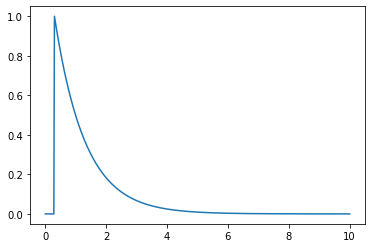

In [31]:
x = np.linspace(0,10,500)
plt.plot(x, sts.gamma(1,0.3).pdf(x))

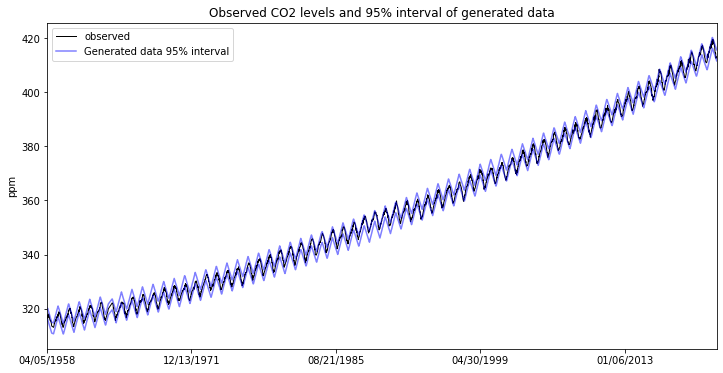

In [32]:
# Plot predictions
current = samples["CO2_present"]
prediction = samples['CO2_future']

# Compute 95% interval of the predicted values
current_interval = np.percentile(current, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(df["Day"], df["CO2"], 'k-', label='observed', linewidth=1)
plt.xlim(0, df.iloc[-1, 0])

plt.plot(df["Day"],
         current_interval[0, :],
         'b-',
         alpha=0.5,
         label='Generated data 95% interval')
plt.plot(df["Day"], current_interval[1, :], 'b-', alpha=0.5)

plt.xticks([i for i in range(0, 25000, 5000)],
           [(datetime.strptime(df_dates.iloc[1, 0], date_format) +
             timedelta(days=i)).strftime(date_format)
            for i in range(0, 25000, 5000)])
plt.ylabel('ppm')
plt.legend()
plt.title('Observed CO2 levels and 95% interval of generated data')
plt.savefig("generated.png", dpi=300)
plt.show()